In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from pyprojroot import here
import seaborn as sns

import searchnets

In [2]:
CKPT_ROOT = here().joinpath('results/searchstims/checkpoints')
NET_EXPT_ROOTS = [path for path in sorted(CKPT_ROOT.iterdir()) if path.is_dir()]

In [3]:
alexnet_expt_roots = [path for path in NET_EXPT_ROOTS if 'alexnet' in str(path)]

convert all tensorboard events files to .csv (only need to run this once)

In [4]:
for alexnet_expt_root in alexnet_expt_roots:
    net_roots = sorted(alexnet_expt_root.joinpath('trained_200_epochs').glob('net_number*'))
    for net_root in net_roots:
        events_file = sorted(net_root.glob('**/*events*'))
        assert len(events_file) == 1, 'found more than one events file'
        events_file = events_file[0]
        logdir = events_file.parent
        searchnets.tensorboard.logdir2csv(logdir)

In [5]:
def get_net_number_from_dirname(dirname):
    return dirname.split('_')[-1]

In [11]:
expt_dfs = {}

for alexnet_expt_root in alexnet_expt_roots:
    expt_name = alexnet_expt_root.name.replace('alexnet_', '')  # will use as dict key
    
    dfs_this_expt = []
    net_roots = sorted(alexnet_expt_root.joinpath('trained_200_epochs').glob('net_number*'))
    for net_root in net_roots:
        net_number = int(
            get_net_number_from_dirname(net_root.name)
        )
        
        events_csv = sorted(net_root.glob('**/*events*csv'))
        assert len(events_csv) == 1, 'found more than one events file'
        events_csv = events_csv[0]
        df = pd.read_csv(events_csv)
        df['replicate'] = net_number
        dfs_this_expt.append(df)
        expt_dfs[expt_name] = pd.concat(dfs_this_expt)

In [12]:
expt_dfs.keys()

dict_keys(['initialize_lr_1e-03_multiple_stims_128000samples_balanced', 'initialize_lr_1e-03_multiple_stims_white_background_128000samples_balanced', 'transfer_lr_1e-03_no_finetune_multiple_stims_128000samples_balanced', 'transfer_lr_1e-03_no_finetune_multiple_stims_white_background_128000samples_balanced'])

In [15]:
expt_dfs['initialize_lr_1e-03_multiple_stims_128000samples_balanced'].columns

Index(['step', 'loss/train', 'loss/val', 'acc/val', 'replicate'], dtype='object')

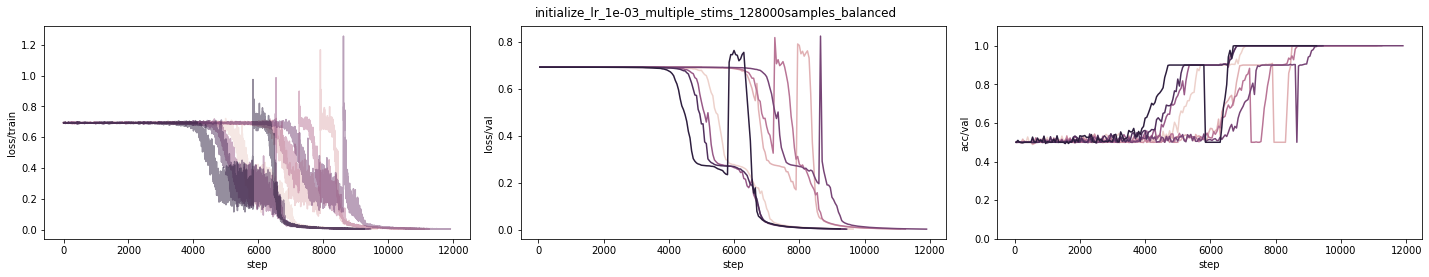

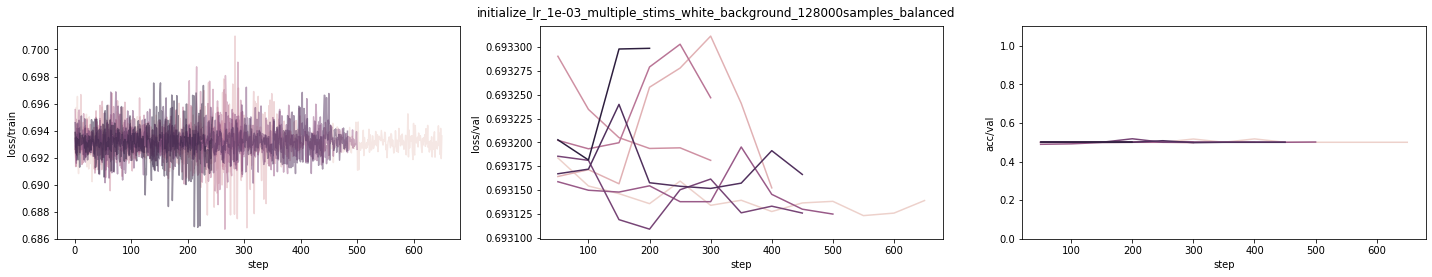

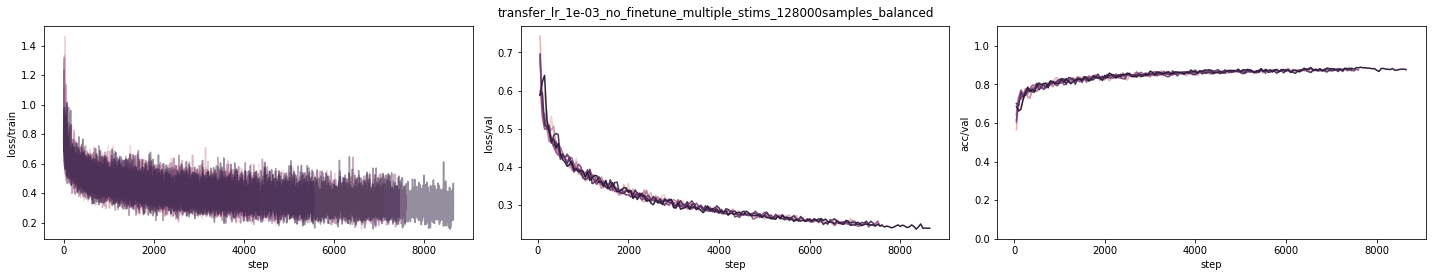

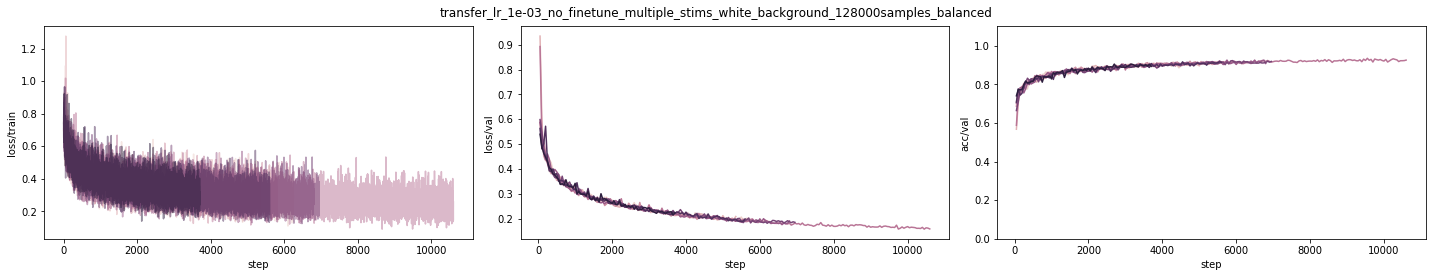

In [16]:
for expt_name in expt_dfs.keys():
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    ax = ax.ravel()
    sns.lineplot(x='step', y='loss/train', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, alpha=0.5, ax=ax[0]);
    # ax[0].set_ylim([0., 0.7])
    sns.lineplot(x='step', y='loss/val', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, ax=ax[1]);
    # ax[1].set_ylim([0., 0.7])
    sns.lineplot(x='step', y='acc/val', hue='replicate', data=expt_dfs[expt_name], 
                 ci=None, legend=False, ax=ax[2]);
    ax[2].set_ylim([0., 1.1])
    st = fig.suptitle(expt_name)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
